In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import re
import time
import random
import os
import pickle
import joblib

from pandas.tseries.offsets import *
from operator import *

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

from IPython.display import Image

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Defining Metric

In [4]:
#Defining metric.
def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean(((y - yhat)/y)**2))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    rmspe = np.sqrt(np.mean(((y - yhat)/y)**2))
    return "rmspe", rmspe


scorer = make_scorer(rmspe, greater_is_better=False)


In [5]:
df_train = pd.read_csv('data/data/train.csv')
df_store = pd.read_csv('data/data/store.csv')


In [6]:
#Joining store data and train data.
df = pd.merge(df_train, df_store, how='left', on='Store')

In [7]:
df['StateHoliday'].replace(0, '0', inplace=True)

In [8]:
X = df.drop(['Sales'], axis=1)
y = df['Sales']

In [9]:
X.columns

Index(['Store', 'DayOfWeek', 'Date', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
X.drop(['Open'], axis=1, inplace=True)

## Create Baseline model

In [11]:
base_x = X[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear']]

In [12]:
base_df = pd.concat([base_x,y], axis=1)

In [13]:
cat_cols = []
for i in base_df.columns:
    if base_df[i].dtype == 'object':
        cat_cols.append(i)

num_cols = [i for i in base_x.columns if i not in cat_cols]

In [14]:
num_transformer = Pipeline(steps = [('imp', IterativeImputer(initial_strategy='median')),
                                    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps = [('imp', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer,num_cols),
                                               ('cat',cat_transformer,cat_cols)]) 

In [15]:
X_transformed = preprocessor.fit(base_x)

In [16]:
from sklearn.model_selection import train_test_split

### RandomForest Regressor

In [17]:
randomforest = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor(max_depth=20,n_jobs=-1, random_state=21))]
)
X_train, X_test, y_train, y_test = train_test_split(
    base_x, y, shuffle=False, random_state=21, test_size=0.2)

In [18]:
randomforest.fit(X_train, y_train)
print("model score: %.3f" % randomforest.score(X_test, y_test))

model score: 0.891


In [19]:
train_preds = randomforest.predict(X_train)
from sklearn.metrics import r2_score

print(r2_score(y_train, train_preds))

0.9027066562050696


In [66]:
### saving the model
from datetime import datetime
pickle.dump(randomforest, open(f'data/model/{datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")}_randomforest.pkl','wb'))

# LSTM Forcasting

In [21]:
from sklearn.preprocessing import MinMaxScaler

sales = base_df['Sales'].to_frame()
scaler = MinMaxScaler()
sales.head()

,Sales
0,5263
1,6064
2,8314
3,13995
4,4822


In [22]:
scaler.fit(sales.values.reshape([-1, 1]))
salesScaled = scaler.transform(sales.values.reshape(-1, 1))
sales['salesScaled'] = salesScaled
sales.head(10)

,Sales,salesScaled
0,5263,0.126664
1,6064,0.145941
2,8314,0.200091
3,13995,0.336815
4,4822,0.116050
5,5651,0.136002
6,15344,0.369281
7,8492,0.204375
8,8565,0.206132
9,7185,0.172920


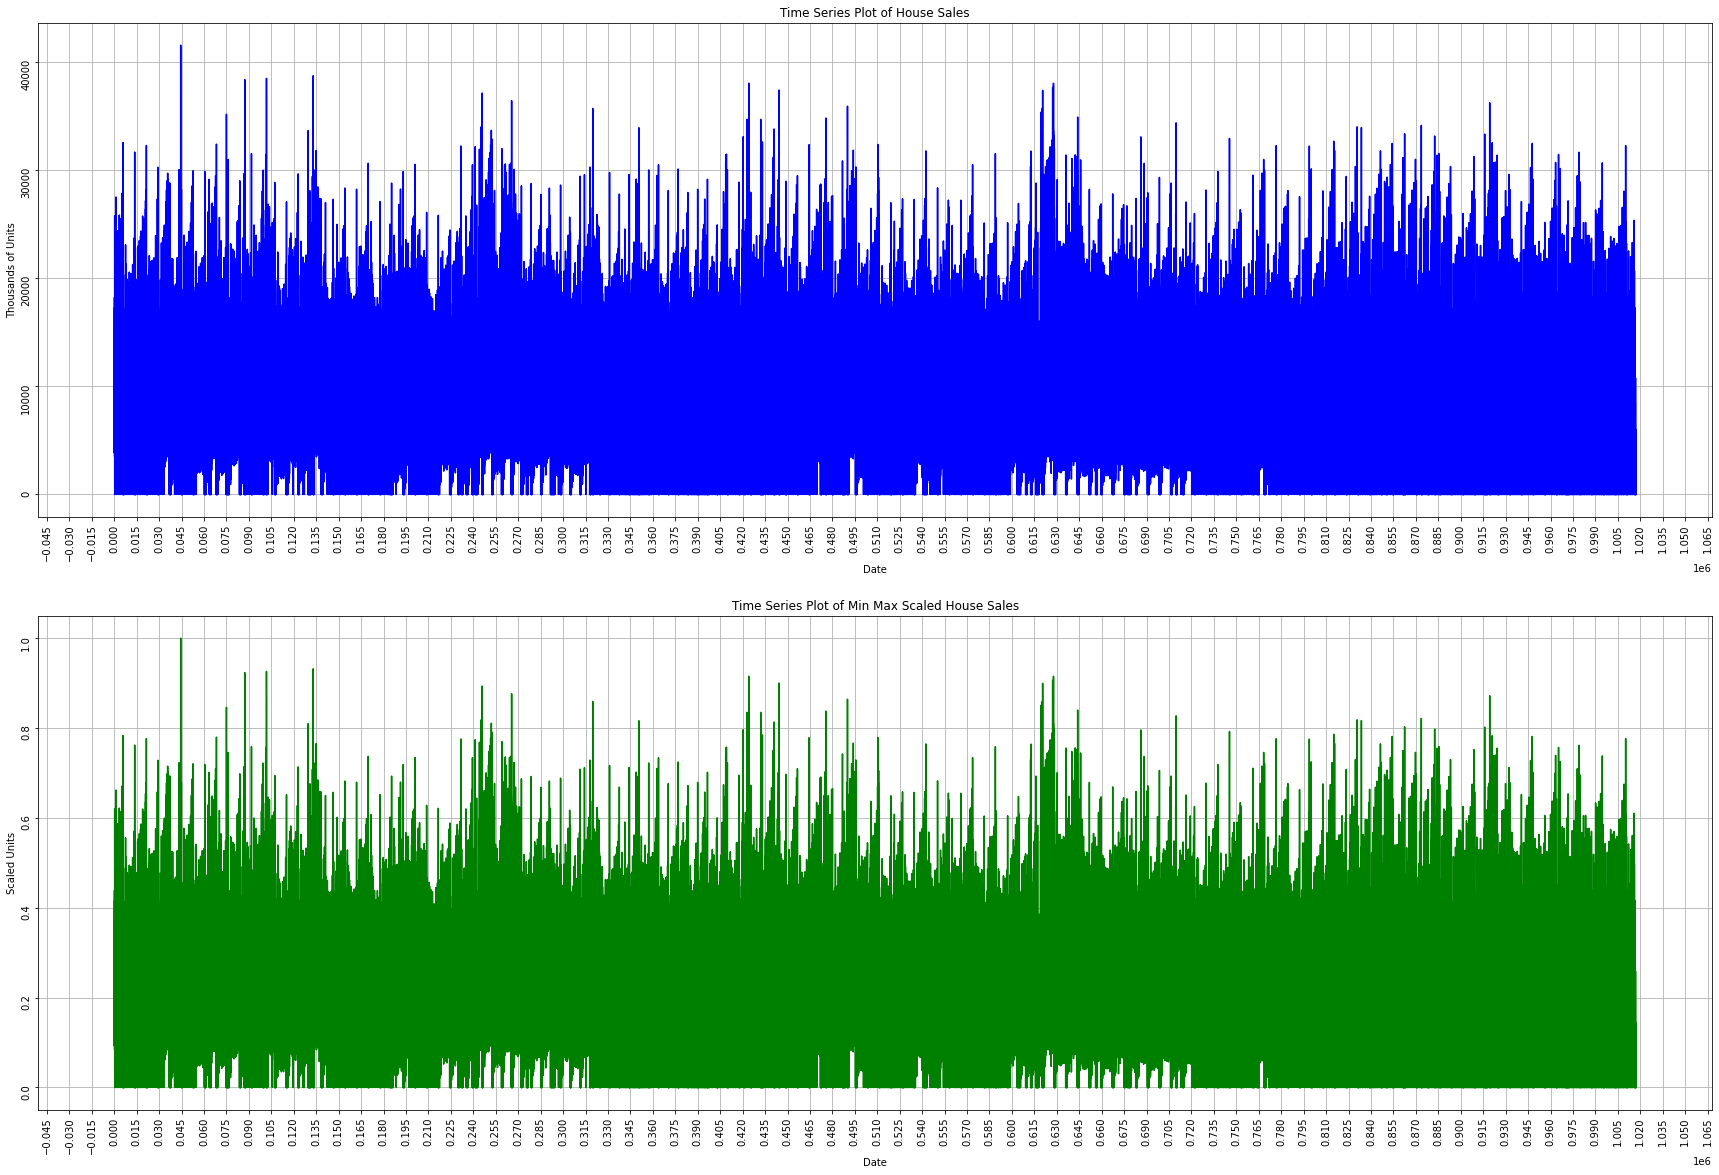

In [23]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sales.index, sales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(sales.index, sales.salesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

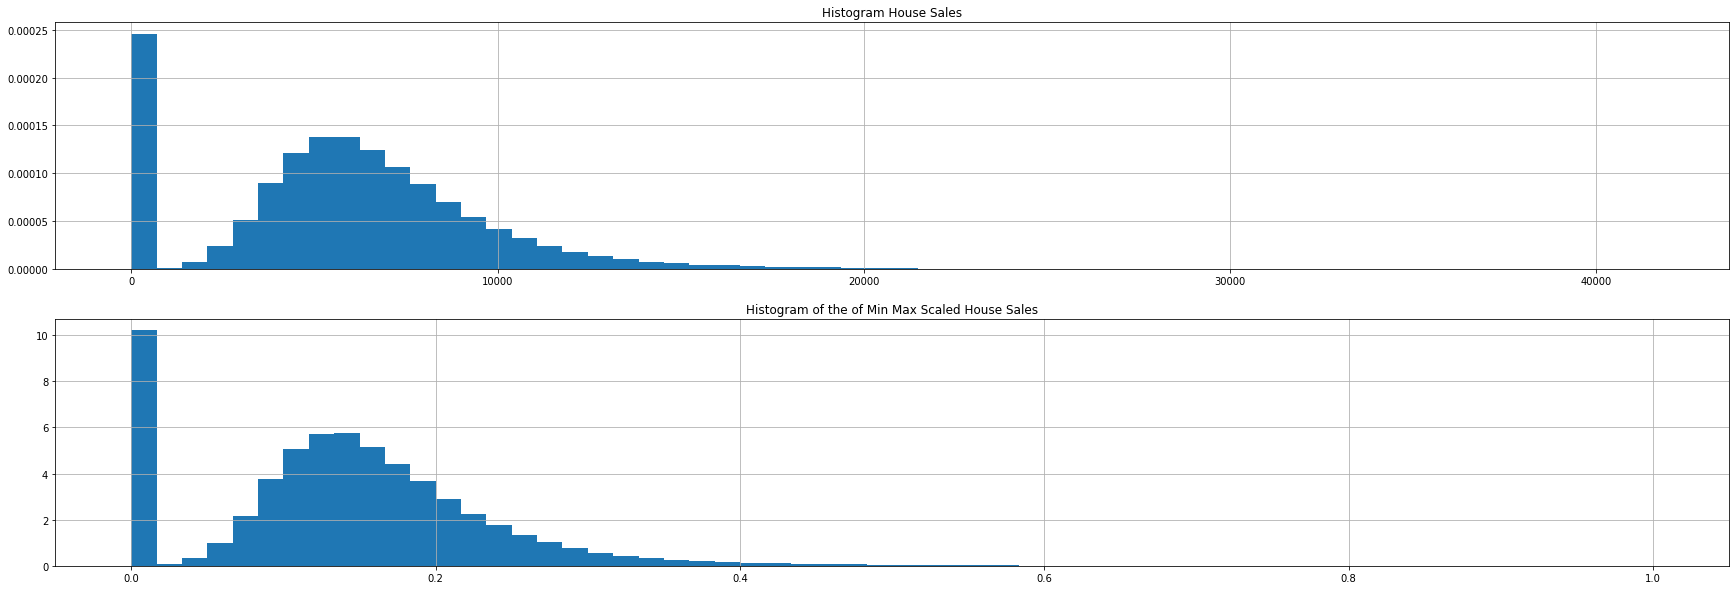

In [24]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(sales.salesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

#### Removing Stationarity

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

In [25]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [26]:
salesDif = difference(sales.salesScaled.values)

### Autocorrelations and Partial Autocorrelations Plots.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

In [27]:
acfSalesScaled = acf(sales.salesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [28]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

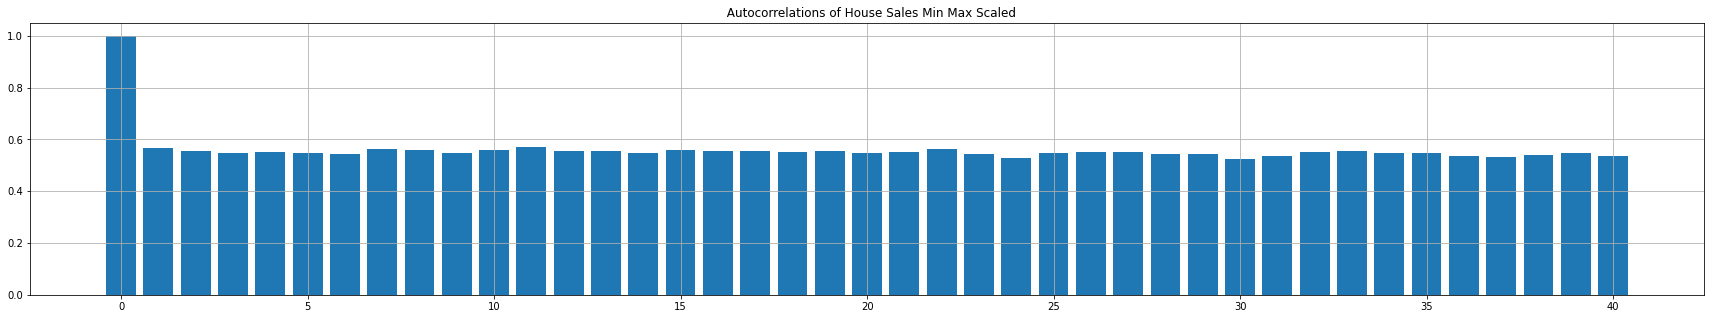

In [29]:
corrPlots(acfSalesScaledNp, '')

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed

In [30]:
pacfSalesScaled = pacf(sales.salesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

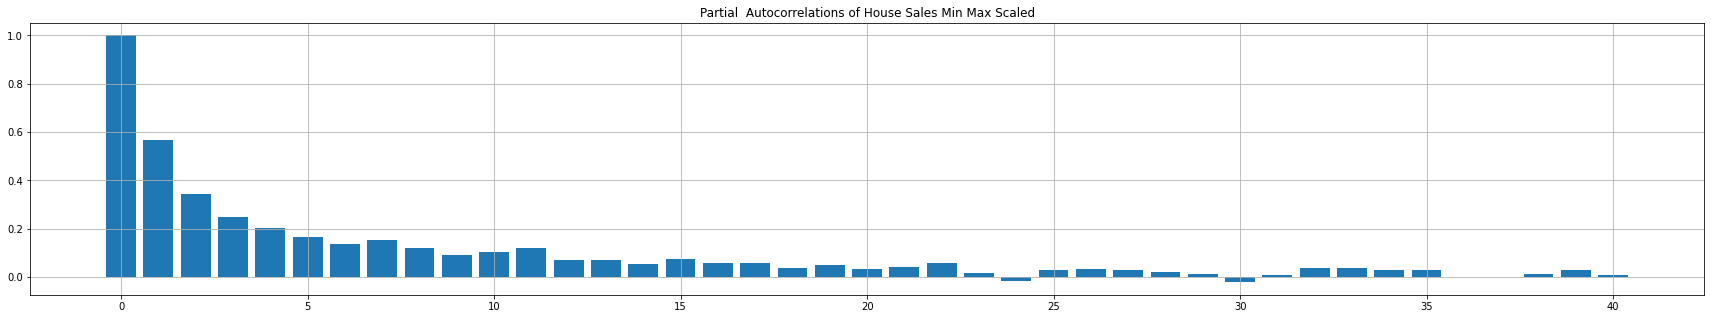

In [31]:
corrPlots(pacfSalesScaledNp, "Partial")

### Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [45]:
SIZE = len(sales.salesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 10

In [46]:
DateTrain = sales.index.values[0:BATCH_SIZE]
DateValid = sales.index.values[BATCH_SIZE:]
XTrain = sales.salesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = sales.salesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (1017113, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (1017113,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [47]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([1017113, 1])

In [48]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [49]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [50]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [51]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [52]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [53]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [54]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [55]:
model = Sequential()
model.add(LSTM(4, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(2, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 4)           96        
                                                                 
 lstm_3 (LSTM)               (None, 2)                 56        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/10
1/1 [==============================] - 103s 103s/step - loss: 0.0040 - val_loss: 2.2702e-04
Epoch 2/10
1/1 [==============================] - 96s 96s/step - loss: 0.0035 - val_loss: 2.6987e-04
Epoch 3/10
1/1 [==============================] - 96s 96s/step - loss: 0.0031 - val_loss: 3.4791e-04
Epoch 4/10
1/1 [==============================] - 92s 92s/step - loss: 0.0028 - val_loss: 4.6095e-04
Epoch 5/10
1/1 [==============================] - 94s 94s/step - loss: 0.0025 - val_loss: 6.0697e-04
Epoch 6/10
1/1 [==============================] - 93s 93s/step - loss: 0.0023 - val_loss: 7.8135e-04
Epoch 7/10
1/1 [==============================] - 94s 94s/step - loss: 0.0022 - val_loss: 9.7596e-04
Epoch 8/10
1/1 [==============================] - 93s 93s/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/10
1/1 [==============================] - 93s 93s/step - loss: 0.0022 - val_loss: 0.0014
Epoch 10/10
1/1 [==============================] - 93s 93s/step - loss: 0.0022 - val_loss: 0.0015

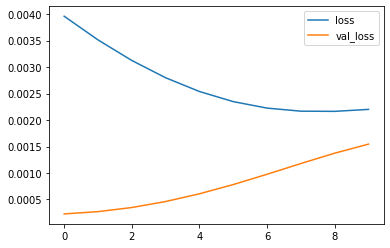

In [58]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [ ]:
pickle.dump(model, open(f'data/model/{datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")}_lstm.pkl','wb'))

In [68]:
model.save(f'data/model/{datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")}_lstm.pkl')

### Forecast the LSTM on the Validation Set and Assess Accuracy.

In [59]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [61]:
Forecast = model_forecast(model, sales.salesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

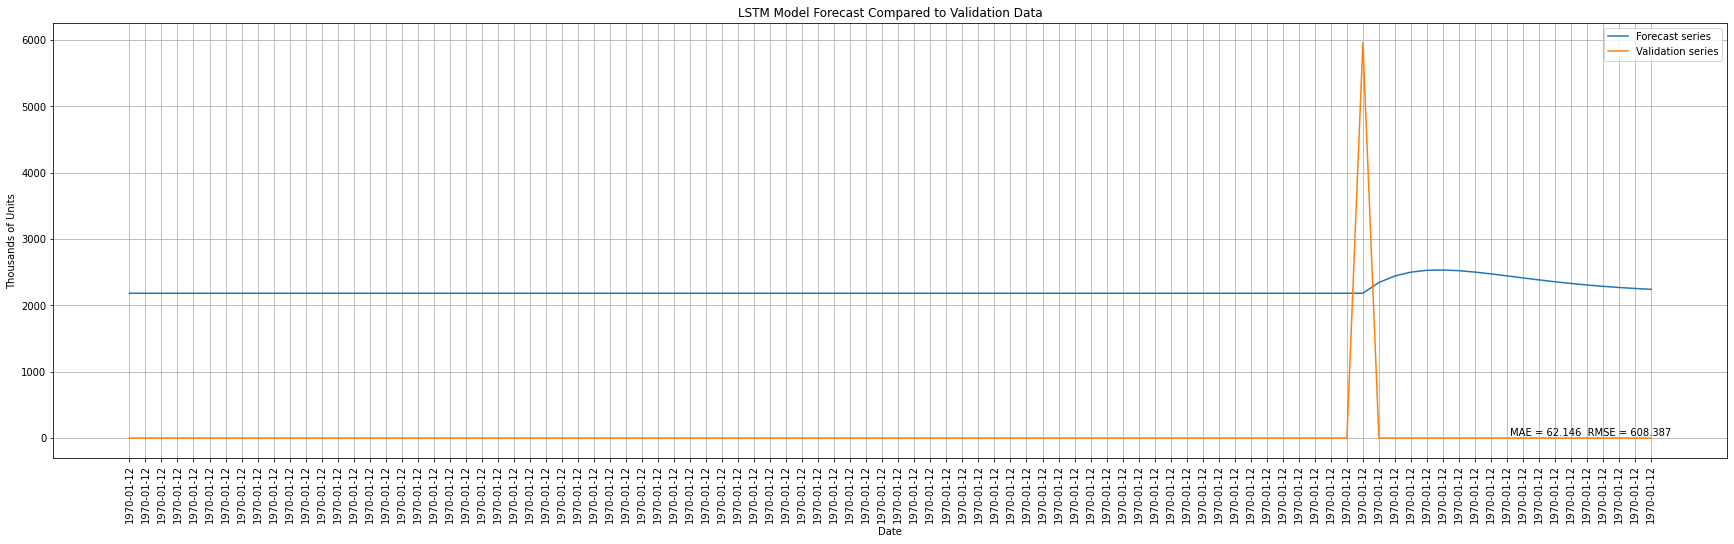

In [62]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [63]:
print(textstr)

MAE = 62.146  RMSE = 608.387
